# Imports

In [1]:
import os
import cv2
import utils
import pickle
from utils import MetricLogger
import numpy as np
import torch
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
import torch.utils.data
import transforms as T
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from engine import train_one_epoch, evaluate

# set paths and parameters

In [2]:
BASE_PATH = os.path.join("..")
DATA_PATH = os.path.join(BASE_PATH, "data")
MODEL_PATH = os.path.join(BASE_PATH, "model")

CHECKPOINT_FILE = "MRCNN.pth.tar"
TEST_SET_SIZE = 200

NUM_EPOCHS = 30
BATCH_SIZE = 8  # 32
NUM_WORKERS = 4  # 8

# prepare data

#### convert masks to [0, 1]

In [3]:
# datasets = [
#     [os.path.join(DATA_PATH, "bodies", path) for path in sorted(os.listdir(os.path.join(DATA_PATH, "bodies")))],
#     [os.path.join(DATA_PATH, "skins", path) for path in sorted(os.listdir(os.path.join(DATA_PATH, "skins")))]
# ]

# results = {"0,1": 0, "0,255": 0, "other": 0}
# for dataset in datasets:
#     for mask_path in dataset:
#         mask = Image.open(mask_path)
#         if (np.unique(np.array(mask)) == np.array([0, 1])).all():
#             results["0,1"] += 1
#         elif (np.unique(np.array(mask)) == np.array([0, 255])).all():
#             results["0,255"] += 1
#             mask = np.array(mask)
#             mask = np.uint8(mask/255)
#             Image.fromarray(mask).save(mask_path)
#         else:
#             results["other"] += 1
# print(results)

#### augment dataset

In [4]:
# datasets = [
#     [os.path.join(DATA_PATH, "images", path) for path in sorted(os.listdir(os.path.join(DATA_PATH, "images")))],
#     [os.path.join(DATA_PATH, "bodies", path) for path in sorted(os.listdir(os.path.join(DATA_PATH, "bodies")))],
#     [os.path.join(DATA_PATH, "skins", path) for path in sorted(os.listdir(os.path.join(DATA_PATH, "skins")))]
# ]

# results = {"mirrored": 0, "existed": 0}
# for dataset in datasets:
#     for path in dataset:
#         # add mirrored to filename
#         path_split = path.split(".")
#         path_split[-2] = f"{path_split[-2]}_mirrored"
#         new_path = ".".join(path_split)
#         # if it doesn't exist
#         if not os.path.exists(new_path):
#             # save mirrored image
#             image = ImageOps.mirror(Image.open(path)).save(new_path)
#             results["mirrored"] += 1
#         else:
#             results["existed"] += 1
# print(results)

#### define dataset

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, transforms=None):
        self.transforms = transforms
        # load data
        self.image_paths = [os.path.join(DATA_PATH, "images", path) for path in sorted(os.listdir(os.path.join(DATA_PATH, "images")))]
        self.body_paths = [os.path.join(DATA_PATH, "bodies", path) for path in sorted(os.listdir(os.path.join(DATA_PATH, "bodies")))]
        self.skin_paths = [os.path.join(DATA_PATH, "skins", path) for path in sorted(os.listdir(os.path.join(DATA_PATH, "skins")))]
        
    def __getitem__(self, idx):
        # load images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        body = cv2.imread(self.body_paths[idx])
        skin = cv2.cvtColor(cv2.imread(self.skin_paths[idx]), cv2.COLOR_RGB2GRAY)
        
        # apply body mask
        image = Image.fromarray(image*body)
        
        # split into connected components
        n, labels, stats, _ = cv2.connectedComponentsWithStats(skin)
        
        # instances are encoded as different colors
        obj_ids = np.unique(labels)
        
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        
        # split into binary mask per object id
        masks = np.array([np.where(labels==obj_id, 1, 0).astype("uint8") for obj_id in obj_ids])

        # get bounding box coordinates for each mask
        boxes = [[stat[0], stat[1], stat[0]+stat[2], stat[1]+stat[3]] for stat in stats[1:]]
        
        # convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # there is only one class
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __len__(self):
        return len(self.image_paths)

In [6]:
def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [7]:
# train test split
dataset = Dataset(get_transform())
dataset_test = Dataset(get_transform())

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-TEST_SET_SIZE])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-TEST_SET_SIZE:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn)

# Define Model

In [8]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and skin
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# move model to device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training

In [ ]:
# start training for NUM_EPOCHS epochs
model.train()
for epoch in range(1, NUM_EPOCHS+1):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
#     lr_scheduler.step()
    # save epoch
    model_path = os.path.join(MODEL_PATH, f"{epoch}_{CHECKPOINT_FILE}")
    torch.save(model.state_dict(), model_path)
    print(f"model {model_path} saved!")

# Evaluation

In [ ]:
# clear memory
torch.cuda.empty_cache()

print("total", torch.cuda.get_device_properties(0).total_memory/1e6)
print("free", (torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0))/1e6)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transform = T.Compose([T.ToTensor()])
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results = {}
for threshold in thresholds:
    print(f"threshold: {threshold}, epoch: ")
    results[threshold] = {}
    for epoch in range(1, NUM_EPOCHS+1):
        print(epoch, end=".. ")
        
        # load
        model_path = os.path.join(MODEL_PATH, f"{epoch}_{CHECKPOINT_FILE}")
        num_classes= 2
        CLASS_NAMES = ['__background__', 'skin']

        model = get_instance_segmentation_model(num_classes)
        model.to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        # evaluate
        IoUs = []
        with torch.no_grad():
            for i, (images, targets) in enumerate(data_loader_test):
                images = [image.to(device) for image in images]

                predictions = model(images)

                images = [image.detach().cpu().numpy() for image in images]
    #             images = [image.permute(1,2,0).detach().cpu().numpy() for image in images]

                targets = [{k: v for k, v in t.items()} for t in targets]

                for j, (image, target, pred) in enumerate(zip(images, targets, predictions)):
                    # merge target
                    target_masks = (target["masks"]).squeeze(dim=1).detach().cpu().numpy()
                    merged_target_mask = np.zeros(target_masks[0].shape, dtype=np.uint8)
                    for mask in target_masks:
                        merged_target_mask[mask == 1] = 1

                    # merge pred
                    pred_masks = (pred["masks"]).squeeze(dim=1).detach().cpu().numpy()
                    merged_pred_mask = np.zeros(pred_masks[0].shape, dtype=np.uint8)
                    for mask in pred_masks:
                        merged_pred_mask[mask > threshold] = 1

                    # display
    #                 plt.imshow(cv2.hconcat([image, image*np.expand_dims(merged_mask, axis=2)]))
    #                 plt.imshow(cv2.hconcat([merged_target_mask, merged_pred_mask]), f"{i+j}")
    #                 plt.show()

                    # calculate IoU
                    intersection = np.sum(cv2.bitwise_and(merged_target_mask, merged_pred_mask) == 1)
                    union = np.sum(cv2.bitwise_or(merged_target_mask, merged_pred_mask) == 1)
                    IoU = intersection/union if union else 0
                    IoUs.append(IoU)
        print()

        # calculate mean IoU
        results[threshold][epoch] = sum(IoUs)/len(IoUs)

# save results
with open(os.path.join(MODEL_PATH, "results.pkl"), "wb") as outfile:
    pickle.dump(results, outfile)

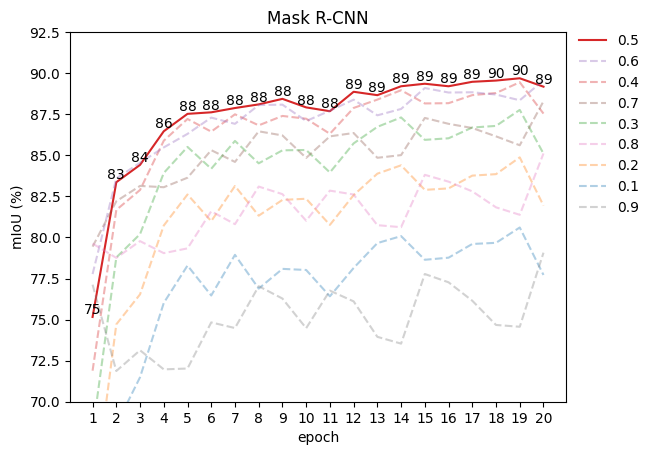

In [11]:
# load results
with open(os.path.join(MODEL_PATH, "results.pkl"), "rb") as infile:
    results = pickle.load(infile)

# epochs to plot
show_epochs = 20
for threshold, result in results.copy().items():
    for epoch, IoU in result.copy().items():
        if epoch > show_epochs:
            del result[epoch]
        else:
            result[epoch] *= 100
    
# plot results
best_IoUs = []
for threshold, result in results.items():
    best_IoUs.append(max(result.values()))
    if threshold == 0.5:
        best = plt.plot(result.keys(), result.values(), color="tab:red", label=threshold)
        for epoch, value in result.items():
            plt.text(x=epoch, y=value, s=f"{value:.0f}", rotation=0, ha="center", va="bottom")
    else:
        plt.plot(result.keys(), result.values(), alpha=0.35, linestyle="--", label=threshold)
   
plt.title(f"Mask R-CNN")
plt.xlabel("epoch")
plt.ylabel("mIoU (%)")

plt.xticks(range(1, show_epochs+1))
plt.ylim([70, 92.5])

handles, labels = plt.gca().get_legend_handles_labels()
handles = reversed(sorted(handles, key=lambda x: best_IoUs[handles.index(x)]))
labels = reversed(sorted(labels, key=lambda x: best_IoUs[labels.index(x)]))
plt.legend(handles, labels, bbox_to_anchor=(1, 1.03), loc="upper left", frameon=False)
    
plt.show()

#### save images

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transform = T.Compose([T.ToTensor()])

image_sets = {}
for epoch in range(1, 20+1):
    print("epoch: ", epoch)
    
    if epoch not in image_sets:
        image_sets[epoch] = []

    # load
    model_path = os.path.join(MODEL_PATH, f"{epoch}_{CHECKPOINT_FILE}")
    num_classes= 2
    CLASS_NAMES = ['__background__', 'skin']

    model = get_instance_segmentation_model(num_classes)
    model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # predict

    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader_test):
            images = [image.to(device) for image in images]

            predictions = model(images)

            images = [image.detach().cpu().numpy() for image in images]
            targets = [{k: v for k, v in t.items()} for t in targets]

            for j, (image, target, pred) in enumerate(zip(images, targets, predictions)):
                # merge target
                target_masks = (target["masks"]).squeeze(dim=1).detach().cpu().numpy()
                merged_target_mask = np.zeros(target_masks[0].shape, dtype=np.uint8)
                for mask in target_masks:
                    merged_target_mask[mask == 1] = 1

                # merge pred
                pred_masks = (pred["masks"]).squeeze(dim=1).detach().cpu().numpy()
                merged_pred_mask = np.zeros(pred_masks[0].shape, dtype=np.uint8)
                for mask in pred_masks:
                    merged_pred_mask[mask > 0.5] = 1

                # add to list
                image_sets[epoch].append([image, merged_pred_mask, merged_target_mask])

In [ ]:
for epoch, images in image_sets.items():
    print("epoch: ", epoch)
    output_path = os.path.join(DATA_PATH, "outputs", str(epoch))
    os.makedirs(output_path, exist_ok=True)
    for i, image_set in enumerate(images):
        image_set = [image_set[0].transpose((1, 2, 0)), cv2.cvtColor(image_set[1], cv2.COLOR_GRAY2RGB), cv2.cvtColor(image_set[2], cv2.COLOR_GRAY2RGB)]
        image_set = [image_set[0], image_set[0]*image_set[1], image_set[0]*image_set[2]]
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(cv2.hconcat(image_set))
        plt.title(f"image, pred, target ({epoch}, {i})")
        plt.tight_layout()
        plt.savefig(os.path.join(output_path, f"image, pred, target ({epoch}, {i})"), bbox_inches="tight")
        plt.close()